In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install pytorch-lightning
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 74.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 18.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
from torchmetrics.functional import auroc, accuracy
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

In [ ]:
class HotelReviewTagger(pl.LightningModule):

  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.dropout = nn.Dropout(0.4)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = self.dropout(output)
    output = torch.sigmoid(output)
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def training_epoch_end(self, outputs):

    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)

    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)

    for i, name in enumerate(LABEL_COLUMNS):
      class_roc_auc = auroc(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)


  def configure_optimizers(self):

    optimizer = AdamW(self.parameters(), lr=2e-5 , weight_decay=0.001)

    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split



df = pd.read_excel('/content/gdrive/MyDrive/SemEval2016_arabic/SemEval2016_arabic/new_dataset.xlsx')
LABEL_COLUMNS = df.columns.tolist()[1:]

In [ ]:
print(len(LABEL_COLUMNS))

8


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 73.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.6 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer
BERT_MODEL_NAME = "CAMeL-Lab/bert-base-arabic-camelbert-da"

tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)

In [ ]:
from transformers import BertModel

bert_model = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)

Some weights of the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-da were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#MODEL_PATH = '/content/drive/MyDrive/hotel-review-epoch9.ckpt'

#trained_model = HotelReviewTagger.load_from_checkpoint(MODEL_PATH, n_classes=len(LABEL_COLUMNS))
#trained_model.eval()
#trained_model.freeze()

In [ ]:
#THRESHOLD = 0.4
#test_comment = "الغرف فسيحة ودورات المياة ممتازة وفخمة ومتكاملة ، لم يعجبني المسبح لانه اصغر مما يجب على فندق خمس نجوم وكذلك عدم وجود واي فاي مجانا"

#encoding = tokenizer.encode_plus(
# test_comment,
# add_special_tokens=True,
#max_length=128,
# return_token_type_ids=False,
# padding="max_length",
# return_attention_mask=True,
# return_tensors='pt',
#)

#_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
#test_prediction = test_prediction.flatten().numpy()
#print(encoding)
#print(LABEL_COLUMNS)
#for label, prediction in zip(LABEL_COLUMNS, test_prediction):
 # if prediction < THRESHOLD:
  #  continue
  #print(f"{label}: {prediction}")

In [ ]:
def to_sentiment(x):
  if x == 'positive':
    return 2
  if x == 'negative':
    return 0
  if x == 'neutral':
    return 1

In [ ]:
aspect_df = pd.read_excel('/content/gdrive/MyDrive/proj/SemEval2016_arabic/SemEval2016_arabic/new_dataset.xlsx')
aspect_df = aspect_df.drop(['rid', 'id', 'from', 'to'], axis=1)
aspect_df = aspect_df.fillna(method='ffill')

In [ ]:
import collections

In [ ]:
# aspect_df["polarity"].count('positive')
collections.Counter(aspect_df['polarity'])

Counter({'positive': 6201, 'negative': 3636, 'neutral': 684})

In [ ]:
aspect_df['sentiment'] = aspect_df.polarity.apply(to_sentiment)
aspect_df

,OutOfScope,text,target,category,polarity,sentiment
0,NaN,نصح نوم تناول طعام موقع مثالي اقامه رحله طيران...,موقع,LOCATION#GENERAL,positive,2
1,NaN,غرفه ممتاز موظف افطار وجبه عشاء مطعم باهظ ثمن ...,الغرفة,ROOMS#GENERAL,positive,2
2,NaN,غرفه ممتاز موظف افطار وجبه عشاء مطعم باهظ ثمن ...,الموظفون,SERVICE#GENERAL,positive,2
3,NaN,غرفه ممتاز موظف افطار وجبه عشاء مطعم باهظ ثمن ...,بوفيه الإفطار,FOOD_DRINKS#QUALITY,positive,2
4,NaN,غرفه ممتاز موظف افطار وجبه عشاء مطعم باهظ ثمن ...,وجبة العشاء,FOOD_DRINKS#PRICES,negative,0
...,...,...,...,...,...,...
10516,1.0,كثير شاي او قهوه كعك منزل كعك اضافي لمسه راءع,الكعك,FOOD_DRINKS#QUALITY,positive,2
10517,1.0,كثير شاي او قهوه كعك منزل كعك اضافي لمسه راءع,كعك,FOOD_DRINKS#QUALITY,positive,2
10518,1.0,افضل افطار فندق صغير كثير خيار عدم وجود متاعب,إفطار,FOOD_DRINKS#STYLE_OPTIONS,positive,2
10519,1.0,افضل افطار فندق صغير كثير خيار عدم وجود متاعب,فندق,HOTEL#DESIGN_FEATURES,positive,2


In [ ]:
MAX_LEN = 128
class_names = ['negative', 'neutral', 'positive']
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [ ]:
df_train, df_val = train_test_split(aspect_df, test_size=0.1, stratify=aspect_df.polarity , random_state=42)

In [ ]:
class HotelReviewDataset(Dataset):

  def __init__(self, reviews, auxilaries, targets, tokenizer, max_len):
    self.reviews = reviews
    self.auxilaries = auxilaries
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    auxilary = str(self.auxilaries[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      auxilary,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=True,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'auxilary': auxilary,
      'token_type_ids': encoding['token_type_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = HotelReviewDataset(
    reviews=df.text.to_numpy(),
    auxilaries=df['target'].to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
print(train_data_loader)

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask, token_type_ids):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest s

dict_keys(['review_text', 'input_ids', 'auxilary', 'token_type_ids', 'attention_mask', 'targets'])

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-da were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
token_type_ids = data['token_type_ids'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length
print(token_type_ids.shape)

torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])


In [ ]:
F.softmax(model(input_ids, attention_mask, token_type_ids), dim=1)

tensor([[0.2611, 0.3607, 0.3782],
        [0.2300, 0.2605, 0.5094],
        [0.3523, 0.2832, 0.3645],
        [0.2667, 0.2889, 0.4444],
        [0.2512, 0.3232, 0.4256],
        [0.1994, 0.4553, 0.3453],
        [0.1451, 0.2940, 0.5609],
        [0.1568, 0.4587, 0.3845],
        [0.1680, 0.4262, 0.4058],
        [0.1700, 0.4184, 0.4116],
        [0.1442, 0.3786, 0.4772],
        [0.2039, 0.2990, 0.4970],
        [0.2470, 0.2768, 0.4762],
        [0.2249, 0.3435, 0.4316],
        [0.2234, 0.2676, 0.5090],
        [0.2334, 0.3136, 0.4530]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

# Training

In [ ]:
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import numpy as np
from collections import defaultdict

In [ ]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False,weight_decay=0.001)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d["token_type_ids"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'bestcamelbert_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `

Train loss 0.5231028450652957 accuracy 0.816751161808196


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val   loss 0.4264822940934788 accuracy 0.845204178537512

Epoch 2/10
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train loss 0.3621881680839972 accuracy 0.8691381495564005


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `

Val   loss 0.4583493434457165 accuracy 0.8480531813865148

Epoch 3/10
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train loss 0.2938555972178693 accuracy 0.8917405999155048


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `

Val   loss 0.563299170215473 accuracy 0.8395061728395062

Epoch 4/10
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `

Train loss 0.25212017430867245 accuracy 0.9079002957329954


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest s

Val   loss 0.6817260129998127 accuracy 0.8309591642924977

Epoch 5/10
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest s

Train loss 0.21934991152728972 accuracy 0.9184621884241656


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val   loss 0.7345491836807041 accuracy 0.8271604938271605

Epoch 6/10
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train loss 0.1993297551576885 accuracy 0.9277566539923954


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest s

Val   loss 0.7895411803866877 accuracy 0.8290598290598291

Epoch 7/10
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest s

Train loss 0.1815791678817658 accuracy 0.9367342627798901


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest s

Val   loss 0.8060322646898302 accuracy 0.8319088319088319

Epoch 8/10
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `

Train loss 0.1684381025171771 accuracy 0.9443388255175327


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest s

Val   loss 0.8449013560841029 accuracy 0.8385565052231719

Epoch 9/10
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train loss 0.15723028316790225 accuracy 0.9471905365441486


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val   loss 0.8974028991704638 accuracy 0.8357075023741691

Epoch 10/10
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `

Train loss 0.1462418295623384 accuracy 0.9506759611322348


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val   loss 0.9251801542528538 accuracy 0.8309591642924977

CPU times: user 34min 9s, sys: 24.1 s, total: 34min 33s
Wall time: 35min 28s


In [ ]:
import matplotlib.pyplot as plt

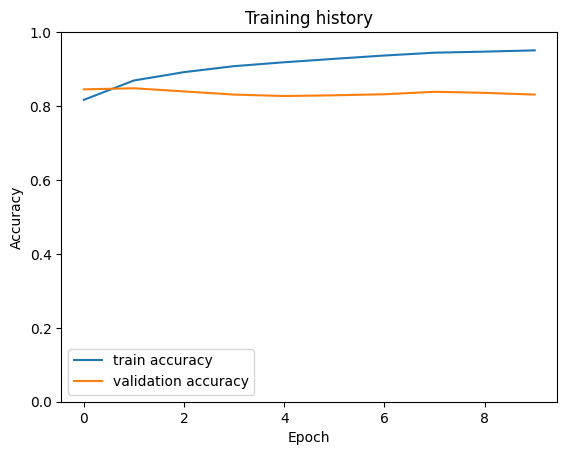

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

train_acc = np.array([item.cpu() for item in history['train_acc']])
val_acc = np.array([item.cpu() for item in history['val_acc']])

plt.plot(train_acc, label='train accuracy')
plt.plot(val_acc, label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

plt.show()





In [ ]:
test_df = pd.read_excel("/content/gdrive/MyDrive/proj/SemEval2016_arabic/SemEval2016_arabic/testgold.xlsx")

test_df = test_df.drop(['rid', 'id', 'from', 'to'], axis=1)
test_df = test_df.fillna(method='ffill')
test_df['sentiment'] = test_df.polarity.apply(to_sentiment)
test_data_loader = create_data_loader(test_df, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
print(test_df.shape)

(2606, 6)


In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(test_df)
)

test_acc.item()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest s

0.8365310821181888

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  auxilary_texts = []
  targets = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      auxilaries = d["auxilary"]
      input_ids = d["input_ids"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      auxilary_texts.extend(auxilaries)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, auxilary_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts,y_auxilary_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest s

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.79      0.89      0.84       927
     neutral       0.45      0.12      0.19       169
    positive       0.88      0.88      0.88      1510

    accuracy                           0.84      2606
   macro avg       0.71      0.63      0.64      2606
weighted avg       0.82      0.84      0.82      2606



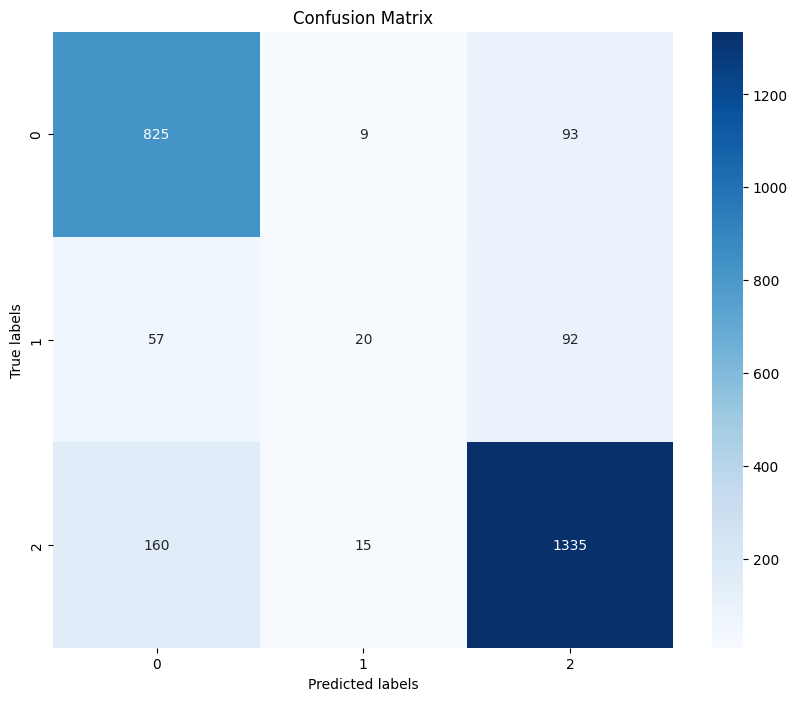

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

## Prediction

In [ ]:
review_text = " كانت الغرفة ممتازة وكذلك الموظفون وبوفيه الإفطار. ومع ذلك فقد كانت وجبة العشاء في المطعم باهظة الثمن وغير مرضية"
target='وجبة العشاء'
encoded_review = tokenizer.encode_plus(
  review_text,
  target,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=True,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

encoding = tokenizer.encode_plus(
  review_text,
  add_special_tokens=True,
  max_length=128,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

#_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
#test_prediction = test_prediction.flatten().numpy()

input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
token_type_ids = encoded_review['token_type_ids'].to(device)

output = model(input_ids, attention_mask, token_type_ids)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'target text: {target}')
print(f'Sentiment  : {class_names[prediction]}')
print(f'Labels  : ')
#for label, prediction in zip(LABEL_COLUMNS, test_prediction):
#  if prediction < THRESHOLD:
#    continue
 # print(f"{label}: {prediction}")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Review text:  كانت الغرفة ممتازة وكذلك الموظفون وبوفيه الإفطار. ومع ذلك فقد كانت وجبة العشاء في المطعم باهظة الثمن وغير مرضية
target text: وجبة العشاء
Sentiment  : negative
Labels  : 


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
model2 = SentimentClassifier(len(class_names))
model2.load_state_dict(torch.load('/content/bestcamelbert_model_state.bin',  map_location=torch.device('cpu')))
model2.eval()
model2.to(device)

Some weights of the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-da were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [ ]:
review_text = "بالنسبة لتناول الطعام بالخارج - لا تذهب إلى تاج محل - طعام متوسط المستوى، وخدمة سيئة جدًا."
target='خدمة'
#['لموظفون','SERVICE#GENERAL']
# target='الموظفون'
#category='SERVICE#GENERAL'
encoded_review = tokenizer.encode_plus(
  review_text,
  target,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=True,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
token_type_ids = encoded_review['token_type_ids'].to(device)

output = model2(input_ids, attention_mask, token_type_ids)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'target text: {target}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: بالنسبة لتناول الطعام بالخارج - لا تذهب إلى تاج محل - طعام متوسط المستوى، وخدمة سيئة جدًا.
target text: خدمة
Sentiment  : negative
